# <font color=blue>Credit Card Fruad Detection</font>

In [65]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [66]:
#import the useful libraries.
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from datetime import datetime

### 1. Data Importing

In [67]:
import pandas as pd
#df = pd.read_csv('/content/gdrive/My Drive/Upgrad Fraud Detection/fraudTrain.csv')
df = pd.read_csv('fraudTrain.csv')

In [68]:
df.shape

(1296675, 23)

In [69]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [71]:
df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

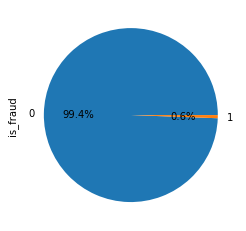

In [72]:
df.is_fraud.value_counts(normalize= True).plot.pie(autopct='%1.1f%%')
plt.show()

##### Data is highly imbalaced with very less fraud transactions (~0.6%)

In [73]:
df['trans_num'].nunique()

1296675

### 2. Data inspection and cleanup

##### Creating an Age column based on DOB

In [74]:
#finding age
#converting 'dob' column to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
df.age.head()

0    31
1    41
2    57
3    52
4    33
Name: age, dtype: int64

In [75]:
df.age.unique()

array([31, 41, 57, 52, 33, 58, 26, 72, 78, 45, 29, 53, 30, 74, 54, 67, 81,
       73, 39, 48, 55, 42, 49, 35, 21, 32, 77, 47, 59, 65, 25, 43, 38, 93,
       83, 22, 64, 36, 40, 19, 62, 37, 84, 44, 24, 92, 91, 69, 61, 68, 34,
       18, 90, 56, 71, 51, 46, 60, 20, 16, 50, 88, 79, 85, 27, 80, 66, 63,
       15, 14, 82, 86, 23, 75, 28, 70, 76, 89, 87, 95, 94, 96, 17],
      dtype=int64)

In [76]:
df['amt'].quantile([0.1, 0.5, 0.95, 0.995])

0.100      4.1100
0.500     47.5200
0.950    196.3100
0.995    844.2226
Name: amt, dtype: float64

In [77]:
df['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [78]:
df['amt'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).apply("{0:.5f}".format)

count    1296675.00000
mean          70.35104
std          160.31604
min            1.00000
1%             1.26000
5%             2.44000
10%            4.11000
25%            9.65000
50%           47.52000
75%           83.14000
90%          136.67000
95%          196.31000
99%          545.99260
max        28948.90000
Name: amt, dtype: object

##### No significant outliers with amount

##### Deriving additonal columns from 'trans_date_trans_time'

In [79]:

#deriving hour
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_hour'] = df['trans_hour'].astype(str)

#deriving 'day of the week'
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.day_name()
#deriving 'year_month'
df['trans_year_month'] = df['trans_date_trans_time'].dt.strftime("%B")


In [80]:
#deriving 'year'
df['trans_year'] = df['trans_date_trans_time'].dt.year


In [81]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,trans_hour,trans_day_of_week,trans_year_month,trans_year
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,31,0,Tuesday,January,2019
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,41,0,Tuesday,January,2019
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,57,0,Tuesday,January,2019
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,52,0,Tuesday,January,2019
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,33,0,Tuesday,January,2019


In [82]:
df['trans_year'].value_counts()

2019    924850
2020    371825
Name: trans_year, dtype: int64

In [83]:
g = df.groupby(["trans_year","trans_year_month"])

In [84]:
g.trans_num.count()

trans_year  trans_year_month
2019        April                68078
            August               87359
            December            141060
            February             49866
            January              52525
            July                 86596
            June                 86064
            March                70939
            May                  72532
            November             70421
            October              68758
            September            70652
2020        April                66892
            February             47791
            January              52202
            June                 57747
            March                72850
            May                  74343
Name: trans_num, dtype: int64

### 3. Univariate and Bi-variate Analysis

C:\Users\rmadhavan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


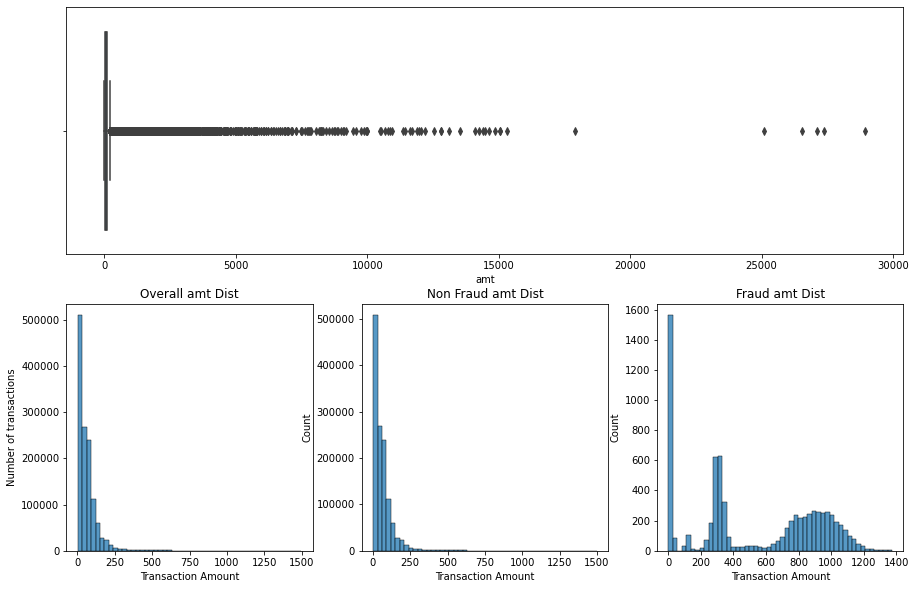

In [85]:
#plotting the amount distributions
fig = plt.subplots(figsize=(15,10))

plots = []
#plotting the amt feature
#box plot
plots.append(sns.boxplot(df.amt, ax=plt.subplot(211)))

#distribution plots
plots.append(sns.histplot(df[df.amt <= 1500].amt, bins=50, ax=plt.subplot(234)))
plots.append(sns.histplot(df[(df.is_fraud==0) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(235)))
plots.append(sns.histplot(df[(df.is_fraud==1) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(236)))

#setting titles
plots[1].set_title('Overall amt Dist')
plots[2].set_title('Non Fraud amt Dist')
plots[3].set_title('Fraud amt Dist')

#setting x labels
plots[1].set_xlabel('Transaction Amount')
plots[2].set_xlabel('Transaction Amount')
plots[3].set_xlabel('Transaction Amount')

#setting y label
plots[1].set_ylabel('Number of transactions')

plt.show()

##### Observation : While normal transactions tend to be around \\$200 or less, we see fraudulent transactions peak at \\$300 and then at the \\$800-\\$1000 range

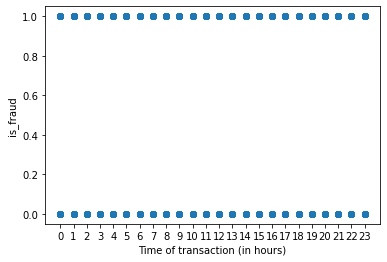

In [86]:
plt.scatter(df['trans_hour'], df['is_fraud'])
plt.xlabel('Time of transaction (in hours)')
plt.ylabel('is_fraud')
plt.show()

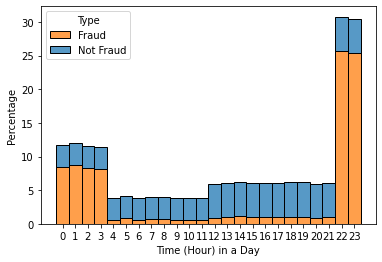

In [87]:
#fix, ax = plt.subplots(figsize=(10,8))

ax = sns.histplot(x='trans_hour', data = df, hue='is_fraud', stat='percent', multiple='stack',common_norm=False)

ax.set_ylabel('Percentage')
ax.set_xlabel('Time (Hour) in a Day')
#plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

#plt.xticks(rotation=90)
plt.show()


##### Odd hours tend to have more fraudeulent transactions than regular hours

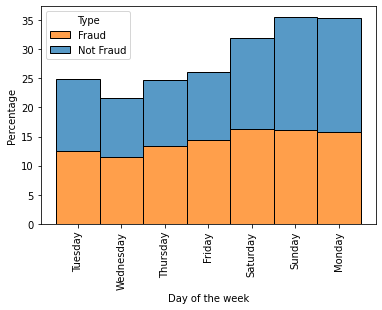

In [88]:
ax = sns.histplot(x='trans_day_of_week', data = df, hue='is_fraud', stat='percent', multiple='stack',common_norm=False)

ax.set_ylabel('Percentage')
ax.set_xlabel('Day of the week')
#plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.xticks(rotation=90)
plt.show()


##### No clear pattern for day of the week

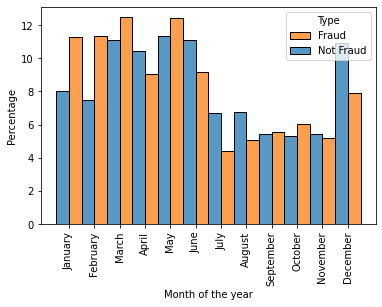

In [89]:

ax = sns.histplot(x='trans_year_month', data = df, hue='is_fraud', stat='percent', multiple='dodge',common_norm=False)

ax.set_ylabel('Percentage')
ax.set_xlabel('Month of the year')
#plt.xticks(np.arange(1,13,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.xticks(rotation=90)
plt.show()


##### Months between Jan and May seem to have higher share of Fraud transaction

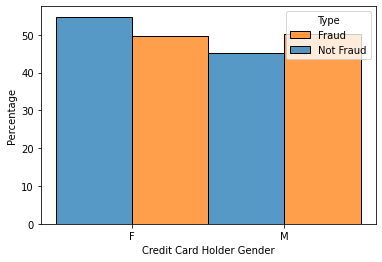

In [90]:
#Gender vs Fraud
ax=sns.histplot(x='gender',data=df, hue='is_fraud',stat='percent',multiple='dodge',common_norm=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Credit Card Holder Gender')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])



##### Males seem to have higher fraud rate compared to females

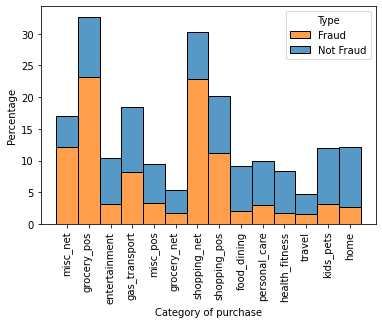

In [91]:
ax = sns.histplot(x='category', data = df, hue='is_fraud', stat='percent', multiple='stack',common_norm=False)

ax.set_ylabel('Percentage')
ax.set_xlabel('Category of purchase')
#plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.xticks(rotation=90)
plt.show()

##### Certain category of purchases have more probability of ending up fraud

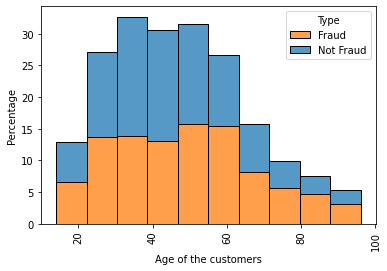

In [92]:
ax = sns.histplot(x='age', data = df, hue='is_fraud', bins=10, stat='percent', multiple='stack',common_norm=False)

ax.set_ylabel('Percentage')
ax.set_xlabel('Age of the customers')
#plt.xticks(np.arange(0,24,1))
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.xticks(rotation=90)
plt.show()

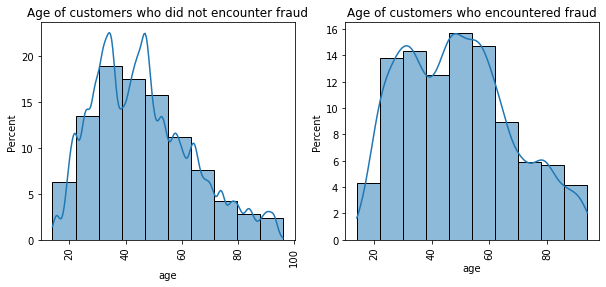

In [93]:
#def bivariate_his_split(col):
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data=df[df['is_fraud']==0], x='age', bins=10, stat='percent', kde=True)
plt.title('Age of customers who did not encounter fraud')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.histplot(data=df[df['is_fraud']==1], x='age', bins=10, stat='percent', kde=True)
plt.title('Age of customers who encountered fraud')
plt.xticks(rotation=90)

plt.show()

##### Between age 40 and 60, more customers are subjected to fraud

<AxesSubplot:xlabel='city_pop', ylabel='Percent'>

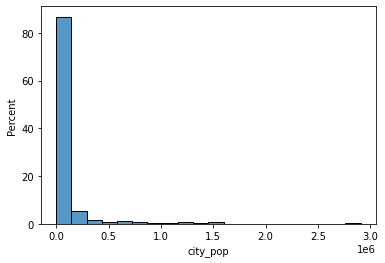

In [94]:
sns.histplot(x='city_pop', data = df[df['is_fraud']==1], bins=20, stat='percent')

<AxesSubplot:>

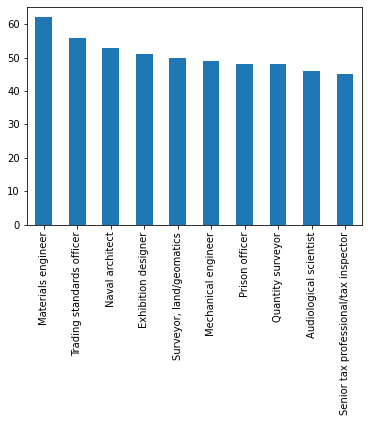

In [95]:
df[df.is_fraud==1].job.value_counts().head(10).plot(kind="bar")

In [96]:
df[df.is_fraud==1].job.value_counts()

Materials engineer                      62
Trading standards officer               56
Naval architect                         53
Exhibition designer                     51
Surveyor, land/geomatics                50
                                        ..
Statistician                             3
Health physicist                         3
Chartered loss adjuster                  3
English as a second language teacher     2
Contractor                               2
Name: job, Length: 443, dtype: int64

##### Job categories such as materials engineer, naval architects are subjected to more fraud

<AxesSubplot:>

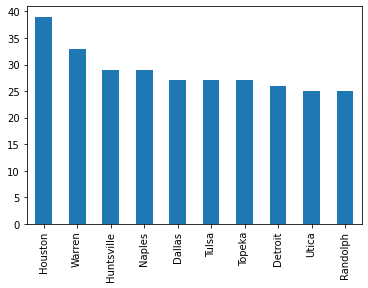

In [97]:
df[df.is_fraud==1].city.value_counts().head(10).plot(kind="bar")

In [98]:
df[df.is_fraud==1].city.value_counts()

Houston           39
Warren            33
Huntsville        29
Naples            29
Dallas            27
                  ..
Florence           3
Kilgore            2
Phoenix            2
Phenix City        2
Denham Springs     2
Name: city, Length: 702, dtype: int64

##### Cities like Houston, Warren has more cases of fraud

<AxesSubplot:>

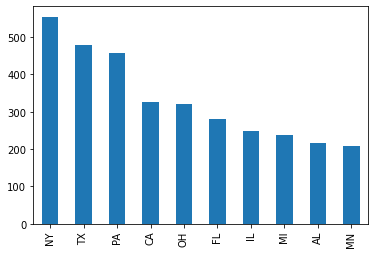

In [99]:
df[df.is_fraud==1].state.value_counts().head(10).plot(kind="bar")

##### NY and TX leads amoung the states for the fraud cases

In [100]:
df['lat_distance'] = abs(round(df['merch_lat']-df['lat'],3))
df['long_distance'] = abs(round(df['merch_long']-df['long'],3))

<AxesSubplot:xlabel='is_fraud', ylabel='lat_distance'>

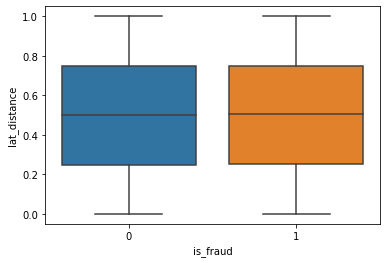

In [101]:
sns.boxplot(data=df,x='is_fraud', y='lat_distance')

<AxesSubplot:xlabel='is_fraud', ylabel='long_distance'>

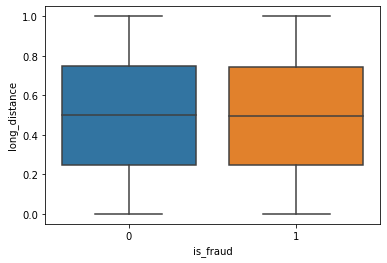

In [102]:
sns.boxplot(data=df,x='is_fraud', y='long_distance')

<AxesSubplot:>

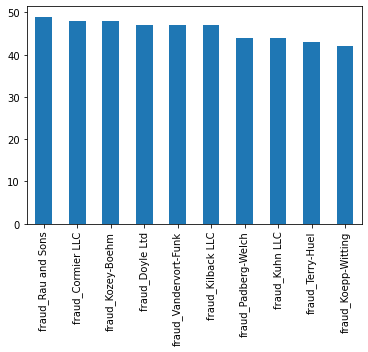

In [103]:
df[df.is_fraud==1].merchant.value_counts().head(10).plot(kind="bar")

##### Certain merchants have more share of fraud cases

In [104]:
zip_tran_total = df.groupby('zip')['trans_num'].count()
zip_tran_fraud = df[df.is_fraud == 1]['zip'].value_counts()
fraud_perc = zip_tran_fraud/ zip_tran_total * 100
fraud_perc.sort_values(ascending=False).head(25)

77027    100.0
75246    100.0
11944    100.0
74108    100.0
11763    100.0
11747    100.0
32065    100.0
61364    100.0
28412    100.0
89109    100.0
10954    100.0
10553    100.0
16041    100.0
10533    100.0
16214    100.0
47842    100.0
10018    100.0
72135    100.0
90240    100.0
23117    100.0
43723    100.0
70065    100.0
12207    100.0
78208    100.0
78644    100.0
dtype: float64

### 4. Preparing for modeling

In [105]:
df_orig = df.copy()

##### dropping unwanted columns that won't add value to the modeling

In [106]:

df.drop(columns=['Unnamed: 0','cc_num','first','last', 'trans_num','unix_time','trans_year_month','trans_hour','trans_year',
                 'trans_date_trans_time', 'dob', 'lat', 'long', 'merch_lat', 'merch_long', 'street', 'zip', 'merchant', 'city', 'state','job'], inplace=True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   category           1296675 non-null  object 
 1   amt                1296675 non-null  float64
 2   gender             1296675 non-null  object 
 3   city_pop           1296675 non-null  int64  
 4   is_fraud           1296675 non-null  int64  
 5   age                1296675 non-null  int64  
 6   trans_day_of_week  1296675 non-null  object 
 7   lat_distance       1296675 non-null  float64
 8   long_distance      1296675 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 89.0+ MB


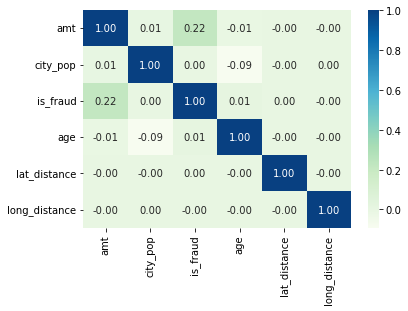

In [108]:
## plot the correlation
#plt.figure(figsize = (,30))
sns.heatmap(df.corr(),annot = True, cmap="GnBu",fmt='.2f')
plt.show()

##### No significant correlation between variables

In [109]:
#dummy encoding for the categorical variables
dummies = pd.get_dummies(df.select_dtypes(include=['object']), drop_first=True)

# dropping the original columns and concatinating the dummy columns
df = df.drop(df.select_dtypes(include=['object']).columns, axis=1)
df = pd.concat([df, dummies], axis=1)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 26 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   amt                          1296675 non-null  float64
 1   city_pop                     1296675 non-null  int64  
 2   is_fraud                     1296675 non-null  int64  
 3   age                          1296675 non-null  int64  
 4   lat_distance                 1296675 non-null  float64
 5   long_distance                1296675 non-null  float64
 6   category_food_dining         1296675 non-null  uint8  
 7   category_gas_transport       1296675 non-null  uint8  
 8   category_grocery_net         1296675 non-null  uint8  
 9   category_grocery_pos         1296675 non-null  uint8  
 10  category_health_fitness      1296675 non-null  uint8  
 11  category_home                1296675 non-null  uint8  
 12  category_kids_pets           1296675 non-n

In [111]:
#sclaing the numerical values
scaler = StandardScaler()


scaler_cols = ['amt','city_pop','age','lat_distance','long_distance']
df[scaler_cols] = scaler.fit_transform(df[scaler_cols])

In [112]:
df.head()

,amt,city_pop,is_fraud,age,lat_distance,long_distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,...,category_shopping_net,category_shopping_pos,category_travel,gender_M,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday
0,-0.407826,-0.282589,0,-0.864629,-1.497948,1.279686,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.230039,-0.293670,0,-0.289333,-0.794479,-1.648963,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0.934149,-0.280406,0,0.631140,1.627812,-1.358175,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.158132,-0.287742,0,0.343492,1.052561,-0.184638,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-0.177094,-0.293835,0,-0.749570,-0.853390,1.141216,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [113]:
from sklearn import model_selection

In [114]:
X = df.drop(['is_fraud'], axis=1)

X.head()

,amt,city_pop,age,lat_distance,long_distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,...,category_shopping_net,category_shopping_pos,category_travel,gender_M,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday
0,-0.407826,-0.282589,-0.864629,-1.497948,1.279686,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.230039,-0.293670,-0.289333,-0.794479,-1.648963,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.934149,-0.280406,0.631140,1.627812,-1.358175,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.158132,-0.287742,0.343492,1.052561,-0.184638,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-0.177094,-0.293835,-0.749570,-0.853390,1.141216,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [115]:
# Putting response variable to y
y = df['is_fraud']

y.head()
y.shape

(1296675,)

### 5. Logistic regression

In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [117]:
num_cv_splits = 5
skf = model_selection.StratifiedKFold(n_splits=num_cv_splits, shuffle=True, random_state=0)

In [118]:
lr = LogisticRegression(C=1.0, random_state=0, max_iter=1000, n_jobs=-1)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
confusion_mats = []

In [119]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Logistic Regression classifier on the training set and evaluate its performance on the testing set
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_mats.append(confusion_mat)


In [120]:
# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_precision_score = np.mean(precision_scores)
avg_recall_score = np.mean(recall_scores)
avg_confusion_mat = np.mean(confusion_mats, axis=0)


In [121]:
# Print the performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average Precision Score:", avg_precision_score)
print("Average Recall Score:", avg_recall_score)
print("Average Confusion Matrix:\n", avg_confusion_mat)

Average Accuracy: 0.9936846164227736
Average F1 Score: 0.0
Average Precision Score: 0.0
Average Recall Score: 0.0
Average Confusion Matrix:
 [[2.576972e+05 1.366000e+02]
 [1.501200e+03 0.000000e+00]]


##### Evaluation metrics show very poor F1 and Precision due to data imbalance

##### Re-running by oversampling with SMOTE technique

In [122]:
# Applying SMOTE to address the data imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [123]:
### Running logistic regression with SMOTE

In [124]:
# Initialize the StratifiedKFold object with the desired number of folds and shuffle parameter
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize the Logistic Regression classifier with the desired hyperparameters
lr = LogisticRegression(C=1.0, random_state=0, max_iter=1000, n_jobs=-1)


# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
confusion_mats = []

# Loop through each fold and split the data into training and testing sets
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Train the Logistic Regression classifier on the training set and evaluate its performance on the testing set
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_mats.append(confusion_mat)

# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_precision_score = np.mean(precision_scores)
avg_recall_score = np.mean(recall_scores)
avg_confusion_mat = np.mean(confusion_mats, axis=0)

In [125]:
# Print the performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average Precision Score:", avg_precision_score)
print("Average Recall Score:", avg_recall_score)
print("Average Confusion Matrix:\n", avg_confusion_mat)

Average Accuracy: 0.8414753998759055
Average F1 Score: 0.8312048315706176
Average Precision Score: 0.8887878444259695
Average Recall Score: 0.7806300017448621
Average Confusion Matrix:
 [[232648.8  25185. ]
 [ 56561.  201272.8]]


##### Performance has improved with SMOTE

### 6.  DecisionTree with SMOTE

In [126]:
# Apply SMOTE to address data imbalance

# Initialize the StratifiedKFold object with the desired number of folds and shuffle parameter
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize the Decision Tree classifier with the desired hyperparameters
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=50, min_samples_leaf=20)

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
confusion_mats = []

# Loop through each fold and split the data into training and testing sets
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Train the Decision Tree classifier on the training set and evaluate its performance on the testing set
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_mats.append(confusion_mat)

# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_precision_score = np.mean(precision_scores)
avg_recall_score = np.mean(recall_scores)
avg_confusion_mat = np.mean(confusion_mats, axis=0)

In [127]:
# Print the performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average Precision Score:", avg_precision_score)
print("Average Recall Score:", avg_recall_score)
print("Average Confusion Matrix:\n", avg_confusion_mat)

Average Accuracy: 0.9227921241988595
Average F1 Score: 0.924755224440071
Average Precision Score: 0.9018274923188268
Average Recall Score: 0.9488794722363588
Average Confusion Matrix:
 [[231200.8  26633. ]
 [ 13180.6 244653.2]]


##### Performance is better than Logistic regression

### 7. Random Forest

In [128]:
# Random Forest without SMOTE

In [129]:
# Initialize the StratifiedKFold object with the desired number of folds and shuffle parameter
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize the Random Forest classifier with the desired hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced')

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
confusion_mats = []

# Loop through each fold and split the data into training and testing sets
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the Random Forest classifier on the training set and evaluate its performance on the testing set
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_mats.append(confusion_mat)

# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_precision_score = np.mean(precision_scores)
avg_recall_score = np.mean(recall_scores)
avg_confusion_mat = np.mean(confusion_mats, axis=0)


In [130]:
# Print the performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average Precision Score:", avg_precision_score)
print("Average Recall Score:", avg_recall_score)
print("Average Confusion Matrix:\n", avg_confusion_mat)


Average Accuracy: 0.972266759211059
Average F1 Score: 0.2397502570899813
Average Precision Score: 0.14250674731991145
Average Recall Score: 0.755130578726477
Average Confusion Matrix:
 [[251009.2   6824.6]
 [   367.6   1133.6]]


##### Without SMOTE the perfomance is poor

### 8. Hyper parameter tuning using Cross Validation

In [131]:
## Run Hyper parameter tuning with GridSearchCV

In [132]:
## this code is disbaled as it takes a long time to run

In [133]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
# Apply SMOTE to address data imbalance


# Initialize the StratifiedKFold object with the desired number of folds and shuffle parameter
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [20, 50],
    'min_samples_leaf': [10, 20]
}

# Initialize the Random Forest classifier with default hyperparameters
rf = RandomForestClassifier()

# Initialize the GridSearchCV object with the desired parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='f1', verbose=1)
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', verbose=2)


In [134]:
%%time
# Fit the GridSearchCV object on the resampled training data
grid_search.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 4h 33min 6s
Wall time: 4h 33min 19s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [10, 20],
                         'min_samples_split': [20, 50],
                         'n_estimators': [50, 100]},
             scoring='f1', verbose=1)

In [135]:
# Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 20, 'n_estimators': 50}


####  Running Random Forest with SMOTE and Hyper parameter values

In [136]:
# Apply SMOTE to address data imbalance

# Initialize the StratifiedKFold object with the desired number of folds and shuffle parameter
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize the Random Forest classifier with the best hyperparameters
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=20, min_samples_leaf=20, class_weight='balanced')

# Initialize lists to store performance metrics for each fold
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
confusion_mats = []

# Loop through each fold and split the data into training and testing sets
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    # Train the Random Forest classifier on the training set and evaluate its performance on the testing set
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    confusion_mats.append(confusion_mat)

# Calculate the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_precision_score = np.mean(precision_scores)
avg_recall_score = np.mean(recall_scores)
avg_confusion_mat = np.mean(confusion_mats, axis=0)

In [137]:
# Print the performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average Precision Score:", avg_precision_score)
print("Average Recall Score:", avg_recall_score)
print("Average Confusion Matrix:\n", avg_confusion_mat)

Average Accuracy: 0.9359618443771481
Average F1 Score: 0.9326057328988313
Average Precision Score: 0.9832489045138282
Average Recall Score: 0.8870473825987176
Average Confusion Matrix:
 [[253934.4   3899.4]
 [ 29123.  228710.8]]


#### Randam Forest with SMOTE gives the best results among all the models

In [882]:
## Running Random Forest on the entire training data

In [138]:
rf = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=20, min_samples_leaf=20)

In [139]:
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=20,
                       n_estimators=50)

In [140]:
rf.feature_importances_

array([7.62379320e-01, 1.63892136e-02, 1.59932255e-02, 2.71682095e-03,
       2.05459947e-03, 1.11997637e-02, 2.62112297e-02, 3.91336209e-03,
       3.24989850e-02, 8.28148506e-03, 1.58150574e-02, 8.75527256e-03,
       1.56018903e-02, 3.86605019e-03, 4.36345859e-03, 4.04232901e-02,
       9.03517389e-03, 6.65719950e-03, 9.33741292e-03, 1.53882037e-03,
       2.67902166e-04, 1.72581751e-03, 1.97322736e-04, 5.15423715e-04,
       2.61903495e-04])

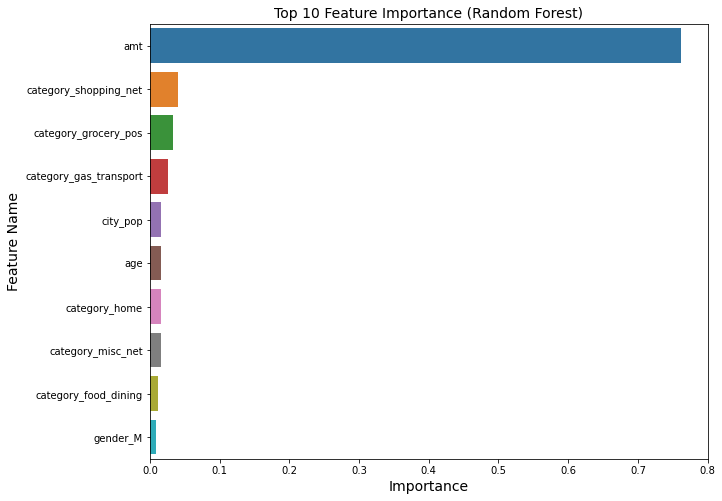

In [141]:
imp_df = pd.DataFrame({
    "Feature Name": X_resampled.columns,
    "Importance": rf.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14)
plt.xlabel ('Importance', fontsize=14)
plt.ylabel ('Feature Name', fontsize=14)
plt.show()

In [142]:
imp_df.sort_values(by="Importance", ascending=False)

,Feature Name,Importance
0,amt,0.762379
15,category_shopping_net,0.040423
8,category_grocery_pos,0.032499
6,category_gas_transport,0.026211
1,city_pop,0.016389
2,age,0.015993
10,category_home,0.015815
12,category_misc_net,0.015602
5,category_food_dining,0.011200
18,gender_M,0.009337


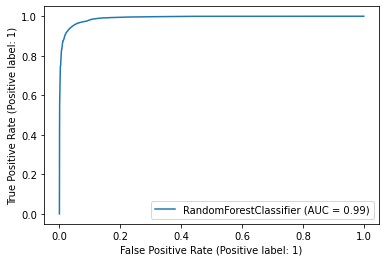

In [143]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

roc_display = metrics.RocCurveDisplay.from_estimator(rf, X_resampled, y_resampled)
#roc_display.plot()

### 9. Testing against unseen data

In [144]:
df_test = pd.read_csv('fraudTest.csv')

In [145]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [146]:
# deriving additonal columns from 'trans_date_trans_time'
#finding age
#converting 'dob' column to datetime
df_test['dob'] = pd.to_datetime(df_test['dob'])
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])
df_test['age'] = df_test['trans_date_trans_time'].dt.year - df_test['dob'].dt.year
df_test.age.head()

#deriving hour
df_test['trans_hour'] = df_test['trans_date_trans_time'].dt.hour
df_test['trans_hour'] = df_test['trans_hour'].astype(str)

#deriving 'day of the week'
df_test['trans_day_of_week'] = df_test['trans_date_trans_time'].dt.day_name()
#deriving 'year_month'
df_test['trans_year_month'] = df_test['trans_date_trans_time'].dt.strftime("%B")



In [147]:
#deriving 'year'
df_test['trans_year'] = df_test['trans_date_trans_time'].dt.year


In [148]:
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,age,trans_hour,trans_day_of_week,trans_year_month,trans_year
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,52,12,Sunday,June,2020
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,30,12,Sunday,June,2020
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,50,12,Sunday,June,2020
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,33,12,Sunday,June,2020
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,65,12,Sunday,June,2020


In [149]:
df_test['trans_year'].value_counts()

2020    555719
Name: trans_year, dtype: int64

In [150]:
g = df_test.groupby(["trans_year","trans_year_month"])

In [151]:
g.trans_num.count()

trans_year  trans_year_month
2020        August               88759
            December            139538
            July                 85848
            June                 30058
            November             72635
            October              69348
            September            69533
Name: trans_num, dtype: int64

In [152]:
df_test['lat_distance'] = abs(round(df_test['merch_lat']-df_test['lat'],3))
df_test['long_distance'] = abs(round(df_test['merch_long']-df_test['long'],3))

In [153]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             555719 non-null  int64         
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   cc_num                 555719 non-null  int64         
 3   merchant               555719 non-null  object        
 4   category               555719 non-null  object        
 5   amt                    555719 non-null  float64       
 6   first                  555719 non-null  object        
 7   last                   555719 non-null  object        
 8   gender                 555719 non-null  object        
 9   street                 555719 non-null  object        
 10  city                   555719 non-null  object        
 11  state                  555719 non-null  object        
 12  zip                    555719 non-null  int6

In [154]:
## Make a copy of the test data before dropping the columns
df_test_orig = df_test.copy()

In [155]:
#sclaing the numerical values
#scaler = StandardScaler()


scaler_cols = ['amt','city_pop','age','lat_distance','long_distance']
df_test[scaler_cols] = scaler.transform(df_test[scaler_cols])

In [156]:
df_test.drop(columns=['Unnamed: 0','cc_num','first','last', 'trans_num','unix_time','trans_hour','trans_year_month','trans_year',
                 'trans_date_trans_time', 'dob', 'lat', 'long', 'merch_lat', 'merch_long', 'street', 'zip', 'merchant', 'job', 'city', 'state'], inplace=True)

In [157]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           555719 non-null  object 
 1   amt                555719 non-null  float64
 2   gender             555719 non-null  object 
 3   city_pop           555719 non-null  float64
 4   is_fraud           555719 non-null  int64  
 5   age                555719 non-null  float64
 6   trans_day_of_week  555719 non-null  object 
 7   lat_distance       555719 non-null  float64
 8   long_distance      555719 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 38.2+ MB


In [158]:
#dummy encoding for the categorical variables
dummies = pd.get_dummies(df_test.select_dtypes(include=['object']), drop_first=True)

# dropping the original columns and concatinating the dummy columns
df_test = df_test.drop(df_test.select_dtypes(include=['object']).columns, axis=1)
df_test = pd.concat([df_test, dummies], axis=1)

In [159]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   amt                          555719 non-null  float64
 1   city_pop                     555719 non-null  float64
 2   is_fraud                     555719 non-null  int64  
 3   age                          555719 non-null  float64
 4   lat_distance                 555719 non-null  float64
 5   long_distance                555719 non-null  float64
 6   category_food_dining         555719 non-null  uint8  
 7   category_gas_transport       555719 non-null  uint8  
 8   category_grocery_net         555719 non-null  uint8  
 9   category_grocery_pos         555719 non-null  uint8  
 10  category_health_fitness      555719 non-null  uint8  
 11  category_home                555719 non-null  uint8  
 12  category_kids_pets           555719 non-null  uint8  
 13 

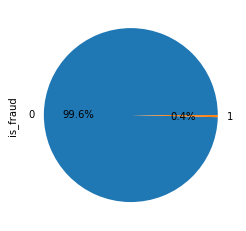

In [160]:
df_test.is_fraud.value_counts(normalize= True).plot.pie(autopct='%1.1f%%')
plt.show()

In [161]:
# Load the unseen test data
X_test = df_test.drop('is_fraud', axis=1)
y_test = df_test['is_fraud']

# Use the trained Random Forest model to make predictions on the test data
y_test_pred = rf.predict(X_test)

# Evaluate the performance of the model on the test data using accuracy score, F1 score, precision, recall, and confusion matrix
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
confusion_mat = confusion_matrix(y_test, y_test_pred)


In [162]:
print("Test Accuracy:", accuracy)
print("Test F1 Score:", f1)
print("Test Precision Score:", precision)
print("Test Recall Score:", recall)
print("Test Confusion Matrix:\n", confusion_mat)

Test Accuracy: 0.9840584899922443
Test F1 Score: 0.2929204246148935
Test Precision Score: 0.17671417565485362
Test Recall Score: 0.8554778554778555
Test Confusion Matrix:
 [[545025   8549]
 [   310   1835]]


In [163]:
print(sklearn.metrics.classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.18      0.86      0.29      2145

    accuracy                           0.98    555719
   macro avg       0.59      0.92      0.64    555719
weighted avg       1.00      0.98      0.99    555719



#### With unseen data model gives good Accuracy and Recall

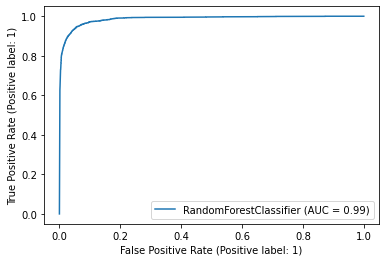

In [164]:
roc_display = metrics.RocCurveDisplay.from_estimator(rf, X_test, y_test)

In [165]:
metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

0.9866522979898968

##### AUC value of 0.99 indicates good performance of the model

### 10. Cost Benefit Analysis

#### Data preparation

In [166]:
inp1 = df_test_orig[['amt', 'is_fraud']]

In [167]:
# Creating dataframe of y_pred

df_test_pred = pd.DataFrame(y_test_pred)
df_test_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [168]:
inp1 = pd.concat([inp1, df_test_pred],axis=1)

In [169]:
inp1.head()

,amt,is_fraud,0
0,2.86,0,0
1,29.84,0,0
2,41.28,0,0
3,60.05,0,0
4,3.19,0,0


In [170]:
# Renaming column

inp1 = inp1.rename(columns={ 0 : 'is_fraud_pred'})
inp1.head()

,amt,is_fraud,is_fraud_pred
0,2.86,0,0
1,29.84,0,0
2,41.28,0,0
3,60.05,0,0
4,3.19,0,0


In [171]:
# Train datat + test data will give the results for 24 months. 
# To evalute the cost for 24 months, merging the train and test data

In [172]:
# runnig the model on the taining set 
y_train_pred = rf.predict(X)

In [173]:
df_orig.shape

(1296675, 30)

In [174]:
inp0 = df_orig[['amt', 'is_fraud']]

In [175]:
# Creating dataframe of y_train_pred

df_train_pred = pd.DataFrame(y_train_pred)
df_train_pred.head()

,0
0,0
1,0
2,0
3,0
4,0


In [176]:
inp0 = pd.concat([inp0, df_train_pred],axis=1)

In [177]:
# Renaming column

inp0 = inp0.rename(columns={ 0 : 'is_fraud_pred'})
inp0.head()

,amt,is_fraud,is_fraud_pred
0,4.97,0,0
1,107.23,0,0
2,220.11,0,0
3,45.00,0,0
4,41.96,0,0


In [178]:
# Merging train and test dataset for cost benefit analysis

df_final = pd.concat([inp0, inp1],axis=0)
df_final.head()

,amt,is_fraud,is_fraud_pred
0,4.97,0,0
1,107.23,0,0
2,220.11,0,0
3,45.00,0,0
4,41.96,0,0


In [179]:
df_final.shape

(1852394, 3)

#### Calculation of cost benefit 

In [180]:
# Average number of transactions per month
        
avg_txn = len(df_final)/24
avg_txn

77183.08333333333

In [181]:
# Average Number of fraudulent transactions per month

avg_fraud_txn = len(df_final[df_final['is_fraud']==1])/24
avg_fraud_txn

402.125

In [182]:
# Average amount per fraud transaction

avg_fraud_amt = df_final[df_final['is_fraud']==1].amt.mean()
avg_fraud_amt

530.6614122888789

In [183]:
# Average number of transactions per month detected as fraud by the model

TF = len(df_final[df_final['is_fraud_pred']==1])/24
TF

1554.75

In [184]:
# Average number of transactions per month that are fraudulent but are not detected by the model

Undetected_frauds = df_final.loc[(df_final.is_fraud_pred==0) & (df_final.is_fraud==1)]
FN = len(Undetected_frauds)/24
FN

50.75

In [185]:
# Average number of transactions per month that are fraudulent and detected by the model

detected_frauds = df_final.loc[(df_final.is_fraud_pred==1) & (df_final.is_fraud==1)]
TP = len(detected_frauds)/24
TP

351.375

In [186]:
#Cost incurred per month before the model was deployed =
# Average amount per fraudulent transaction * Average number of fraudulent transactions per month

cost_before_model = avg_fraud_amt * avg_fraud_txn
cost_before_model

213392.22041666543

In [187]:
# Total cost of providing customer support per month for fraudulent transactions detected by the model
#                  = 1.5 * TF.Total cost of providing customer support per month for fraudulent transactions detected by the model = 1.5 * TF.

1.5 * TF

2332.125

In [188]:
# Cost incurred due to these fraudulent transactions left undetected by the model 
#            = Average amount per fraudulent transaction * FN

avg_fraud_amt * FN

26931.066673660604

In [189]:
#Therefore, the cost incurred per month after the model is built and deployed = 
#    1.5*TF + Average amount per fraudulent transaction * FN

cost_after_model = (1.5 * TF) + (avg_fraud_amt * FN)
cost_after_model

29263.191673660604

In [190]:
Final_savings = cost_before_model - cost_after_model
Final_savings

184129.02874300483

### Based on the past 24 months data, total savings through the model will be \\$184,129